# Supplementary Source Code 3 – Crop Reference System

This Jupyter notebook describes the crop reference system algorithm and associated libraries that can run on either a PC or a HPC cluster for defining initial reference positions of a given plot based on the pre-processed crop growth image series processed by the SC2-Crop_ImageSelection_PC_V1.02 script. 

Based on the Jupyter server, we provide an interactive environment to facilitate a range of computer vision and machine learning libraries imports, our tailored and modulated functions to define the initial plot location so that the following batch image processing and automated phenotypic analysis can be carried out based on the reference position identified in the beginning of the crop monitoring. This script includes:
  
* Execute codes and associated mathematical models
* Define the plot initial reference position for a given plot monitored by CropQuant workstations in the field
* Generate locational information regarding the plot region and intermediate processing results to explain the workflow to identify plot region 
* Provide pixel-metric units (cm) transformation algorithm

## Please note that:   
* A Jupyter notebook is ONLY used for demonstrating the algorithm, NOT for batch processing big crop image series.
* The performance of the algorithm provided for the CropQuant breeding project could be varied due to an end-user's computing resources such as physical memory and CPU speed.
* Users might encounter issues with specific libraries if they have not installed properly or not been optimised for Linux-based operating systems.
* We recommend users to preinstall the latest open Anaconda Python distribution before using functions and modules in the CropQuant analysis pipeline that requires Scikit-image or Scikit-learning functions. 


In [1]:
#################################################################
#                                                               #
#    Author: Dr Ji Zhou (周济), ji.zhou@earlham.ac.uk or         #
#                        ji.zhou@jic.ac.uk                      #  
#    Date: 24th August 2015, V0.1 24th May 2015                 #
#                                                               #
#    Version: 1.01 on TGAC internal Github                      #
#    SciPy version: 0.17.0, Scikit-image: 0.12.3                #
#    OpenCV version: 2.4.11, Sklearn: 0.17.1                    #
#                                                               #
#    Software license: the bespoke CropQuant Software License   #
#    the algorithm below is developed by Dr Zhou and his team,  #
#    which shall only be used for research purpose.             #
#                                                               #
#    Version changes:                                           #
#    1) Modulate the code                                       #
#    2) Change the setting of measuring scaler and              #
#       the reference points                                    #
#    3) Change the output csv to record initial                 # 
#       reference positions                                     #
#    4) Update with the latest Anaconda distribution            #
#                                                               #
#################################################################

% matplotlib inline

#STEP 1: Import libraries 
from matplotlib import pyplot as plt # Plotting
import math # for geometric analysis
import os # For access the file system
import numpy as np
from scipy import ndimage # Use for multi-dimensional image processing
import gc # garbage collection

In [2]:
#STEP 2: Select an image file for establishing initial geometirc positions 
# of the monitored plots 

##STEP 2.1: GUI dialog panel to locate where to read images 
import Tkinter, tkFileDialog

# make a top-level instance, but without displaying it
root = Tkinter.Tk() 
root.withdraw()
root.overrideredirect(True) 
# Almost invisible - no decorations, 0 size, top left corner.
root.geometry('0x0+0+0')
root.deiconify() # show window and lift it to top 
root.lift() # otherwise dialogs will place behind the terminal.
root.focus_force()

# Assign the selected filename with a full path
fullname = tkFileDialog.askopenfilename(parent=root)
# print str(fullname).replace(".jpg", "")
root.destroy() # get rid of the top-level instance 
# Finish read the full path from local file system

In [3]:
##STEP 2.2: Reassemble the directory of the initial reference image 
# print fullname
# Get the full path of the image
fullPath = fullname.split("/", -1) 
fullPathRef = '/'.join(fullPath[: -1]) + '/' 
# mac or unix only, Windows should be
# fullPath = fullname.split("\\", -1) # change it to 1
# fullPathRef = '\\'.join(fullPath[: -1]) + '\\' 
print fullPathRef

/Users/zhouj/Documents/My papers/CropQuant/Submission/Supplementary/New Phytologist/Reference Image/


In [4]:
#STEP 3: Prepare the file for analysis
import glob

##STEP 3.1: Start to read the file system - prepared for high-throughput CropMeasurer
CurrentDir = os.getcwd()
# print CurrentDir 
tmp_Folders = []
tmp_Folders_Final = []
workingRootFolder = fullPathRef

# Locate the image directoriy 
# print "Work directory: ",workingRootFolder

# Loop through the working folder, testing for batch processing 
for root, dirs, files in os.walk(workingRootFolder):
    Work_Dir_Root = root
    tmp_Folders.append(dirs)
    tmp_Folders_Final = filter(None, tmp_Folders) 
    # A fast way to get rid of empty elelment while usign os.walk 
    # when going through a file instead of a folder
    
# Directories found in the root folder 
if not len(tmp_Folders_Final) == 0:
    workDirFolders = tmp_Folders_Final[0] 
else: 
    workDirFolders = workingRootFolder
# First level of the working directory, use ONE to search the second level of the directory

# In case this folder has been processed
print "Last Root: ", workDirFolders


Last Root:  ['SHORT_Processed_3-10-2017']


In [5]:
### Function 1: read the local machine time

def LocalTimeStamp(): 
    # Current date and time
    currentDate = time.localtime(time.time())
    return currentDate

In [6]:
### Function 2: enable the file copy
import shutil

def copyImgFile(source, destination):
    try:
        shutil.copy2(source, destination) # Mate data will be included 
    # eg. src and dest are the same file
    except shutil.Error as e:
        print 'Error: %s' % e
    # eg. source or destination doesn't exist
    except IOError as e:
        print 'Error: %s' % e.strerror

In [7]:
##STEP 3.2: Set up a result folder to contain the processing results  
import time
from datetime import datetime, timedelta

# Get the pre-processing date 
timeStamp = LocalTimeStamp()
curYear = timeStamp[0]
curMonth = timeStamp[1]
curDay = timeStamp[2]

# Assemble the result folder 
genotypeID = fullPath[-1].split('_', -1) 
# print genotypeID
Result_Folder = genotypeID[0] + '_CropRef_%d' %curDay + '-%d' %curMonth + '-%d' %curYear
Result_Directory = workingRootFolder + Result_Folder

# If repeating the selection again with different criteria 
if not os.path.exists(Result_Directory):
    os.makedirs(Result_Directory)
    print Result_Directory

/Users/zhouj/Documents/My papers/CropQuant/Submission/Supplementary/New Phytologist/Reference Image/SHORT_CropRef_3-10-2017


Resolution: (1458, 1944, 3)
Mean differnce:  0.0602221332751
Median difference:  0.0782135076253
Gamma:  0.680983504513


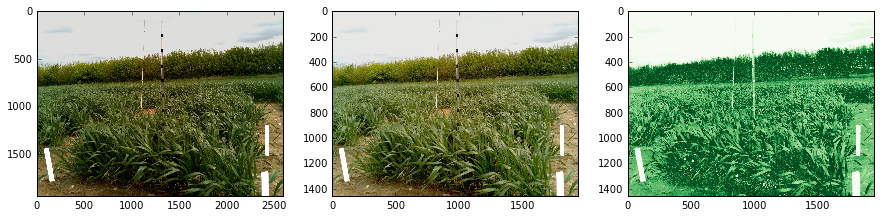

In [8]:
from skimage import color
from skimage import img_as_float
from skimage import img_as_ubyte
from skimage import io # import IO libraries for reading images 
from skimage.transform import rescale
from skimage import exposure

##STEP 3.3: Prepare the images for detection 
Ref_Image_List = glob.glob(workingRootFolder + "/*.jpg")

# print ImageFiles
Ref_Img_tmp = Ref_Image_List[0] # Change the index while looping  
Reference_Image = io.imread(Ref_Img_tmp) # Buffer the image
Wheat_Resize = rescale(Reference_Image, 0.75) # 25% more pixels 
Wheat_hsv = color.rgb2hsv(Wheat_Resize)
Wheat_Value = Wheat_hsv[:, :, 2] # Choose the value channel for dynamic gamma correction 

print "Resolution:", Wheat_hsv.shape
print 'Mean differnce: ', abs(Wheat_Resize.mean() -  Wheat_Value.mean())
print "Median difference: ", abs(np.median(Wheat_Resize) - np.median(Wheat_Value))

# Modify gamma - not useful for the reference but for image screening
# Balance intensity distribution should be close to a 50% balanced spread 
if np.median(Wheat_Value) != 0.525:
    gamma_ratio = np.median(Wheat_Value)/0.525
    print "Gamma: ", gamma_ratio
    gamma_corrected_Img = exposure.adjust_gamma(Wheat_Resize, gamma_ratio)
else: 
    gamma_corrected_Img = Wheat_Resize
    
# Plotting the result of gamma correction 
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows = 1, figsize = (15, 10))
ax1.imshow(Reference_Image)
ax2.imshow(gamma_corrected_Img, cmap ='gray') 
ax3.imshow(Wheat_hsv[:, :, 1], cmap = 'Greens') # The green channel, reference looks very different   

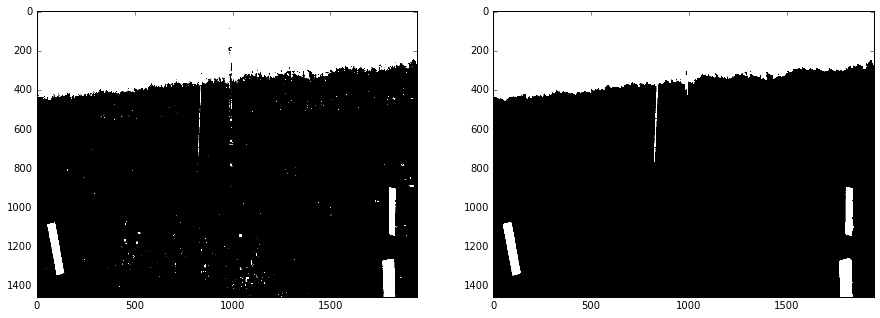

In [9]:
from skimage.morphology import disk, erosion, dilation, opening, closing
from skimage.morphology import remove_small_objects
from skimage import filters

#STEP 4: Extract the white reference points - white canes 
##STEP 4.1: Extract the white reference points - white canes  
# Based on normalised gray scale images
# Detecting the white reference points with high saturation value
whiteRefSize = 12500 
Wheat_hsv = color.rgb2hsv(gamma_corrected_Img)
Wheat_Saturation = Wheat_hsv[:, :, 1]
global_thresh = filters.threshold_otsu(Wheat_Saturation)
binary_global = Wheat_Saturation < global_thresh * 0.30 
# Only keep 1SD - 68.27 - 30% of the pixels

# Get rid of small objects
binary_global_Ref = remove_small_objects(binary_global, 125)
# Close objects to fill holes in detected objects
selem = disk(2) # 2-pixel kernel 
dilated_binary_global = dilation(binary_global_Ref, selem)
# Fill holes in objects
fill_objects = ndimage.binary_fill_holes(dilated_binary_global)
closed_binary = closing(dilated_binary_global, selem)
# Remove objects after closing
binary_global_closed = remove_small_objects(closed_binary, whiteRefSize * 0.5) 
# Reference points are over 12500 pixels

# Plotting the result of gamma correction 
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows = 1, figsize = (15, 15))
ax1.imshow(binary_global, cmap ='gray')
ax2.imshow(binary_global_closed, cmap ='gray') 

Reference 1 size: 9081
Reference 2 size: 12310
Reference 3 size: 12434
X range 96 1816


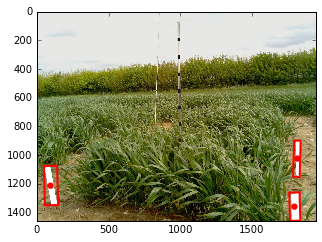

In [10]:
from skimage import feature
from skimage.measure import label, regionprops, find_contours
import matplotlib.patches as ImgPatch

##STEP 4.2: Start select features based on size and WL ratio of the white reference canes 
label_img = label(binary_global_closed, connectivity = 2) # 2D matrix
regions = regionprops(label_img, intensity_image = Wheat_hsv[:, :, 2])

# Set empty array and variables for storing measurements 
Blank_Img = np.zeros((gamma_corrected_Img.shape[0], 
                      gamma_corrected_Img.shape[1]), dtype=np.uint8)
counter = 0
position_Ref_centre = []
label_array = []
bbox_Ref_coor = []
Seg_Img_tmp = Blank_Img.copy()
max_x_col, min_x_col = (0, 0)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5, 5))
ax.imshow(gamma_corrected_Img)

for region in regions:
    # remove small or very big images
    if region.area < whiteRefSize * 0.5 or region.area > Wheat_hsv[:, :, 2].size * 0.1:
        continue    
    if region.minor_axis_length/region.major_axis_length > 0.425: 
        # WL ratio, remove elongated objects, e.g. very bright straw  
        continue
    # append the label array     
    label_array.append(region.label)
    # Increase the object counter
    counter += 1
    # Understand the 2D coordinates of the reference points
    # print region.bbox 
    # Get the centres of reference points
    position_Ref_centre.append([(region.bbox[3] + region.bbox[1])/2, 
                                (region.bbox[0]+region.bbox[2])/2])
    
    # draw rectangle around white reference points
    minr, minc, maxr, maxc = region.bbox
    bbox_Ref_coor.append([counter, minr, minc, maxr, maxc, round(region.orientation, 2)])
    rect = ImgPatch.Rectangle((minc, minr), maxc - minc, maxr - minr, 
                              angle= region.orientation, fill=False, 
                              edgecolor='red', linewidth=2)
    middle_points = ImgPatch.Circle(((region.bbox[3] + region.bbox[1])/2, 
                                     (region.bbox[0]+region.bbox[2])/2), 
                                    radius = 15, fill= True, linewidth = 2, 
                                    color = 'red') 
    # Add objects to the image 
    ax.add_patch(rect)
    ax.add_patch(middle_points)
    Ref_coord = region.coords.astype(int)
    Seg_Img_tmp[minr:maxr, minc:maxc] = 1
    print "Reference " + str(counter) + " size: " +  str(region.area)
    
    # Set up the column boundary of ROI
    y_coor_tmp = (region.bbox[3] + region.bbox[1])/2
    if counter == 1: 
        min_x_col, max_x_col = (y_coor_tmp, y_coor_tmp)
    elif min_x_col > y_coor_tmp:
        min_x_col = y_coor_tmp
    elif max_x_col < y_coor_tmp:
        max_x_col = y_coor_tmp
    
# print position_Ref_centre
print "X range", min_x_col, max_x_col # define the ROI of the monitored wheat plot
# print bbox_Ref_coor
plt.show()

In [11]:
##STEP 4.3: Apply KMeans to classify pixels 
def flatten_img(img):
    """Convert an image with size (W, L, 3) to (W * L, 3). 
    Flatten the 2D pixels into a 1D where each row is a pixel and the columns are RGB values.
    """
    # Only possible when the image has RGB channels 
    return img.reshape((np.multiply(*img.shape[:2]), 3))

(2834352, 3)


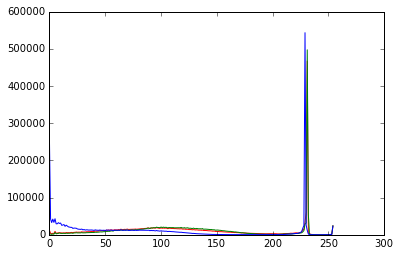

In [12]:
# Flatten both images to get a long list of RGB values in each image.
RGB_bg = flatten_img(gamma_corrected_Img)
print RGB_bg.shape

# Plot RGB histograms for the background.
colours = ['r', 'g', 'b']
for i in range(3):
    y, x = np.histogram(RGB_bg[:, i] * 255.0, bins=range(256))
    plt.plot(range(255), y, colours[i]) 
    # Most of the RGB values are between 200 and 250
    # This is the same case for all five lines

In [13]:
from sklearn.cluster import KMeans

imgFlat = flatten_img(gamma_corrected_Img) # Reshape image to be size (MxN, 3)
# Performs KMeans clustering on the flattened RGB values for image 1.
km = KMeans(n_clusters = 6) 
# print km 
# 6 clusters to roughly represent the plant, bule sky, soil, 
# shadow/markers, cloud/white reference points, other objects
km.fit(imgFlat)
print km.cluster_centers_ # The mean RGB values for the cluster

# Quantise the image based on the selected six clusters.
imgVq = km.cluster_centers_[km.labels_]
imgVq.shape = gamma_corrected_Img.shape


[[ 0.26699036  0.31187499  0.04272137]
 [ 0.90119096  0.90501392  0.89820966]
 [ 0.65641224  0.64587889  0.45753708]
 [ 0.10803137  0.14109492  0.02395099]
 [ 0.39380983  0.42589733  0.15288514]
 [ 0.50409205  0.52687683  0.30949466]]


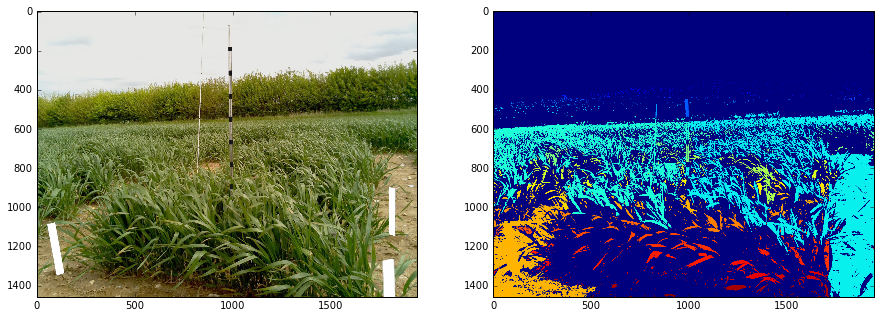

In [14]:
# Present classified pixels, presenting canopy, plot wheelings
# Sky and white reference points are removed due to LOW saturation values 
# values transferred to gray levels in KMeans reclassification   
# Labelled results are used identify the canopy region and darker markers, see below

from skimage import measure
imageGray = color.rgb2gray(imgVq)
all_labels_wheat = measure.label(remove_small_objects(imageGray > np.median(imageGray)*0.95, 5), 
                                 background = 0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
ax1.imshow(gamma_corrected_Img) 
ax2.imshow(all_labels_wheat, cmap = 'jet') 

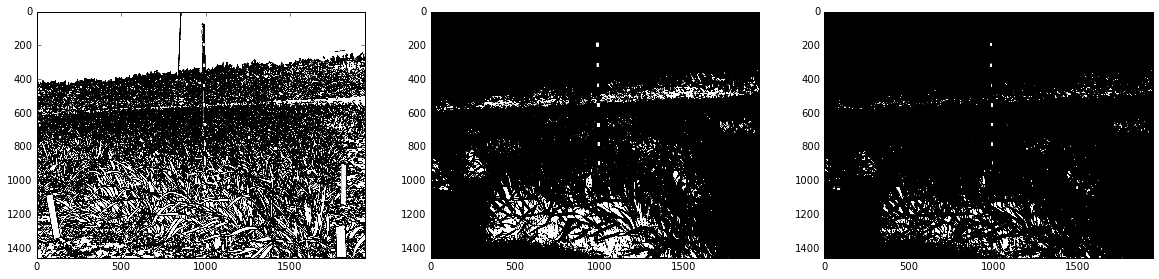

In [15]:
##STEP 4.4: Start select markers on the ranging pole 

# Find markers, based on value of hsv, sigma is for gaussian filter 
# Edge detection using canny
edges_scale = feature.canny(Wheat_hsv[:, :, 2], sigma= 1) 
dilated_ScaleEdge = np.logical_not(dilation(edges_scale, disk(2)))
# Global thresholding using median intensity value, as markers are very dark 
Scale_ROI = Wheat_hsv[:, :, 2] < np.median(Wheat_Value) * 0.5

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 25))
ax1.imshow(dilated_ScaleEdge, cmap= "gray") 
ax2.imshow(Scale_ROI, cmap = 'gray')

# Combine the detection from two approaches 
Scale_ROI_Ref = np.logical_and(Scale_ROI, dilated_ScaleEdge)
ax3.imshow(Scale_ROI_Ref, cmap = 'gray')
# Combine the masks from two approaches highlights the markers on the ranging pole

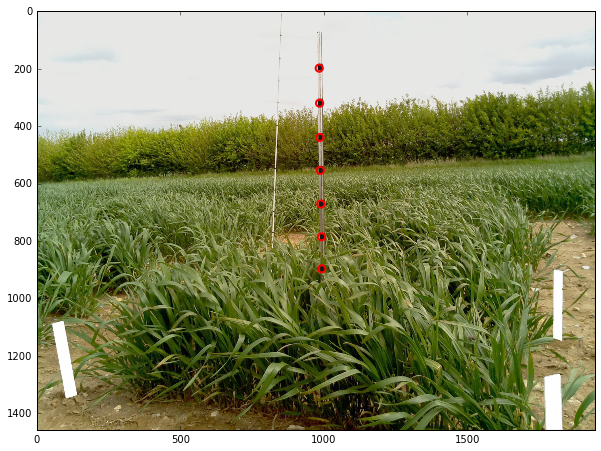

[[1, 983, 197], [2, 985, 319], [3, 986, 439], [4, 987, 553], [5, 989, 670], [6, 991, 785], [7, 992, 896]]


In [16]:
###STEP 4.4.1: Feature selection to locate and measure markers 
label_img_scale = label(Scale_ROI_Ref, connectivity = 1) # label the scale objects 
scale_regions = regionprops(label_img_scale, intensity_image = Wheat_hsv[:, :, 2]) 
# add intensity value channel as a feature

# Set empty array and variables for storing measurements 
counter = 0
position_Scale_centre = []
scale_seg_tmp = Blank_Img.copy()

# Measured based on calculation from the infield workstation
X_coor_Ref = (min_x_col + max_x_col) / 2
min_Y_coor_Ref = 0 
max_Y_coor_Ref = Scale_ROI_Ref.shape[0] # The highest reference point 
markerSize = 225

# Prepare plotting with patches
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 10))
ax.imshow(gamma_corrected_Img)

# Start featre selection 
for region in scale_regions:
    # Remove objects outside the ROI, 10% distance from the Ref centroid point         
    if np.min(region.coords[:, 1]) < X_coor_Ref * 0.95 or np.max(region.coords[:, 1]) > X_coor_Ref * 1.05:
        continue
    if np.min(region.coords[:, 0]) < min_Y_coor_Ref or np.max(region.coords[:, 0]) > max_Y_coor_Ref * 0.75:
        continue    
    # print region.area   
    # remove small or large objects
    if region.area > markerSize * 1.25 or region.area < markerSize * 0.75:
         continue    
    # remove bright objects
    if region.mean_intensity > 0.2: # the object are brighter than 20% of pixels on the image
        continue
    # remove based on width and length    
    #print region.major_axis_length, region.minor_axis_length
    if region.major_axis_length > 25 or region.minor_axis_length > 17.5 or region.major_axis_length < 12.5: 
        continue
    # Remove object with wrong WL ratio
    WL_Ratio = region.minor_axis_length/region.major_axis_length     
    if WL_Ratio < 0.425: 
        continue 
    # Solidity check     
    if region.solidity < 0.5:
        continue
    # print region.mean_intensity, region.eccentricity, region.min_intensity    
    # Finish feature filtering, start to quantify
    counter = counter + 1
    scale_coord = region.coords.astype(int)
    # coordinates based on lablled outlines
    scale_seg_tmp[scale_coord[:,0], scale_coord[:,1]] = 1
    
    # draw rectangle around segmented reference points
    tmp_scale_r, tmp_scale_c = region.centroid
    # rect = ImgPatch.Rectangle((minc, minr), maxc - minc, maxr - minr, angle= region.orientation, 
    #                          fill=False, edgecolor='red', linewidth=2)
    middle_points = ImgPatch.Circle((tmp_scale_c, tmp_scale_r), radius = 12.5, 
                                   fill= False, linewidth = 2, color = 'red') 
    ax.add_patch(middle_points)
    # Add scale positions
    position_Scale_centre.append([counter, int(tmp_scale_c), int(tmp_scale_r)])
    
plt.show()    
print position_Scale_centre
# Finish locating markers 

In [17]:
###STEP 4.4.2: Measure the interval between markers 
distance_list = []
counter = 0
total_x_scale, total_y_scale = (0, 0)
total_x_diff, total_y_diff = (0, 0)

# Read from the marker list
for element, coor_x, coor_y in position_Scale_centre:
    if counter == 0: 
        temp_y0 = coor_y
        temp_x0 = coor_x
        temp_distance_x = 0
        temp_distance_y = 0
    else:
        temp_distance_y = coor_y - temp_y0
        temp_distance_x = coor_x - temp_x0
        distance_list.append([counter, temp_distance_x, temp_distance_y])
        temp_y0 = coor_y
        temp_x0 = coor_x
    counter = counter + 1
    total_x_scale = total_x_scale + coor_x
    total_y_scale = total_y_scale + coor_y
    total_x_diff = total_x_diff + temp_distance_x
    total_y_diff = total_y_diff + temp_distance_y
    
# print type(distance_list), total_x_scale, total_y_scale, total_x_diff, total_y_diff
distanceArray = np.array(distance_list)
# print distanceArray
print "Average distance between markers are: ", np.mean(distanceArray[:, 2]) # in pixels

Average distance between markers are:  116.5


In [18]:
#STEP 5: Prepare to combine detected objects and establish a pseudo 3D reference system

import copy # for shallow and deep copy lists 

##STEP 5.1: Calculate two markers that covered by the plot 
New_Row_1 = 0 
New_Row_2 = 0
X_Diff, Y_Diff = (0, 0)

# Calculate two markers based on visible markers
X_Diff = total_x_scale/len(position_Scale_centre) + total_x_diff/len(distance_list)
Y_Diff = np.median(distanceArray[:, 2]) 
print X_Diff, Y_Diff
# There is a 1 degree deviated from the acute angle, due to the angle between the CropQuant camera 
# and the ranging pole
xDiviateDegree = math.sin(1.0 * math.pi/180)
yDiviateDegree = math.tan(1.0 * math.pi/180)
New_Row_1 = [len(position_Scale_centre) + 1, int(X_Diff*(1+xDiviateDegree * 0.5)), 
             int((position_Scale_centre[-1][2]) + Y_Diff*(1 + yDiviateDegree))] 
New_Row_2 = [len(position_Scale_centre) + 2, int(X_Diff*(1+xDiviateDegree * 0.5)), 
             int(position_Scale_centre[-1][2] + Y_Diff*(1 + yDiviateDegree) + Y_Diff*(1 + yDiviateDegree))]

position_Scale_centre_Ref = []
position_Scale_centre_Ref = copy.copy(position_Scale_centre)

position_Scale_centre_Ref.append(New_Row_1)
position_Scale_centre_Ref.append(New_Row_2)

# Prodcue the marker list 
# print position_Scale_centre_Ref

988 116.0


In [19]:
##STEP 5.2: Calculate the crop plot region
# Y-axis diviation for Ref point 4
Distance_3_1 = math.sqrt(math.pow(abs(position_Ref_centre[2][0]-position_Ref_centre[0][0]), 2) + 
                         math.pow(abs(position_Ref_centre[2][1]-position_Ref_centre[0][1]), 2))
# X-axis diviation for Ref point 4
Distance_2_1 = math.sqrt(math.pow(abs(position_Ref_centre[1][0]-position_Ref_centre[0][0]), 2) + 
                         math.pow(abs(position_Ref_centre[1][1]-position_Ref_centre[0][0]), 2))
# Prepare new Plot Region list
position_Ref_centre_Ref = []
position_Ref_centre_Ref = copy.copy(position_Ref_centre)
# on x-axis, CropQuant for Rht-1 shows a 24 degree diviation, see the side-camera setting   
# on y-axis, CropQuant has 5 degree diviation, based on the alignment between Ref 1 and Ref 3 points  
position_Ref_centre_Ref.append([int(Distance_2_1 * math.tan(24.0 * math.pi/180)), 
                            int((position_Ref_centre[2][1]-Distance_3_1) * (1-math.sin(5.0 * math.pi/180)))])

# swap Ref point 2 and Ref point 3, for following geometric reference system
a = position_Ref_centre_Ref[1]
b = position_Ref_centre_Ref[2]
position_Ref_centre_Ref[1] = b
position_Ref_centre_Ref[2] = a
print position_Ref_centre_Ref

[[1816L, 1024L], [1795L, 1359L], [96L, 1213L], [811, 934]]


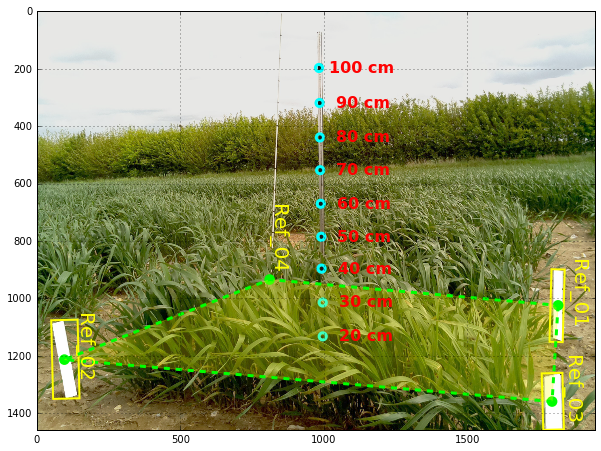

In [20]:
##STEP 5.3: Plotting with patches to present the constructed reference system 

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 10))
plt.grid(True)
ax.imshow(gamma_corrected_Img)

text_interval = 50 / len(position_Scale_centre)

for counter, coor_x, coor_y in position_Scale_centre_Ref:
    # print counter, coor_y
    middle_points = ImgPatch.Circle((coor_x, coor_y), radius = 12.5, 
                                   fill= False, linewidth = 3, color = 'cyan') 
    ax.add_patch(middle_points)
    ax.text(coor_x + 150, coor_y + 25, '%d cm' %(100 - 10 * (counter - 1)), ha='center', 
            va='bottom', color = 'red', size = 16, fontweight='bold')

# Plot the refernce points
counter_ref = 0 
for ID, minr, minc, maxr, maxc, orientation in bbox_Ref_coor:
    # Read from the extracted list
    Rect_Ref = ImgPatch.Rectangle((minc, minr), maxc - minc, maxr - minr, angle= orientation, 
                              fill=False, edgecolor='yellow', linewidth=2)
    middle_Points_Ref = ImgPatch.Circle((position_Ref_centre[counter_ref][0], position_Ref_centre[counter_ref][1]), 
                                   radius = 15, fill= True, linewidth = 2, color = 'lime') 
    ax.text(position_Ref_centre[counter_ref][0] + 65, position_Ref_centre[counter_ref][1] + 75, 
            'Ref_0%d' %(counter_ref + 1), ha='center', va='bottom', color = 'yellow', size = 20, rotation= -90)
    
    counter_ref = counter_ref + 1
    ax.add_patch(Rect_Ref)
    ax.add_patch(middle_Points_Ref)      
    
# Add the fourth reference point
middle_Points_Ref_4 = ImgPatch.Circle((position_Ref_centre_Ref[-1][0], 
                                       position_Ref_centre_Ref[-1][1]), 
                                   radius = 15, fill= True, linewidth = 2, color = 'lime')
ax.add_patch(middle_Points_Ref_4)

# Add polygon
Polygon_Shadow = ImgPatch.Polygon(position_Ref_centre_Ref, fill = True, alpha = 0.25, 
                                  color = 'yellow')
Polygon_Ref = ImgPatch.Polygon(position_Ref_centre_Ref, fill = False, linestyle = 'dashed',
                               linewidth = 3, color = 'lime', closed = True)
ax.add_patch(Polygon_Shadow)
ax.add_patch(Polygon_Ref)

ax.text(position_Ref_centre_Ref[-1][0] + 25, position_Ref_centre_Ref[-1][1] - 25, 
            'Ref_04', ha='center', va='bottom', color = 'yellow', size = 20, rotation= -90)


fig.savefig(Result_Directory + "/" + 'CropRef_processed.jpg', dpi = 300)

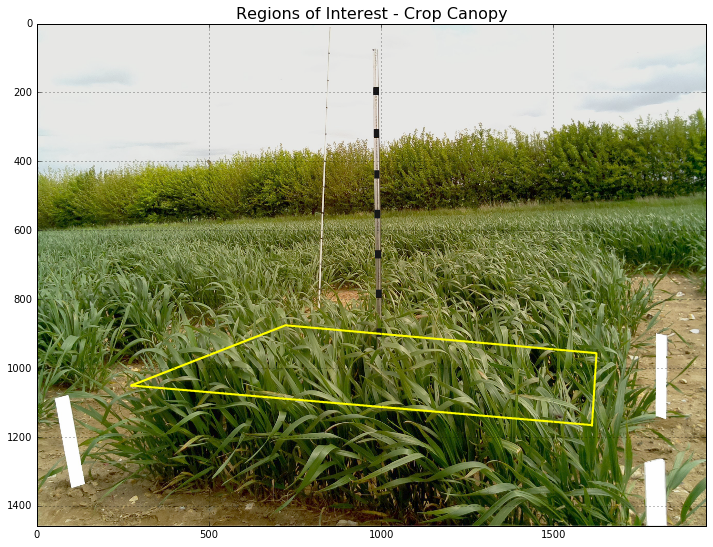

In [21]:
#STEP 6: Export coordinates of the reference system 

from skimage import draw
from skimage.morphology import square
import cv2
from skimage.feature import corner_fast, corner_peaks

##STEP 6.1: Define a smaller region to avoid edge of the plot 
# Reconstruct the ROI using polygon method
Ref_image_region_X = []
Ref_image_region_Y = []
for x_coor, y_coor in position_Ref_centre_Ref:
    Ref_image_region_X.append(x_coor)
    Ref_image_region_Y.append(y_coor)  

# Prepare to relocate a resized region to present canopy 
Ref_image_Region = np.zeros(gamma_corrected_Img.shape)
rr, cc = draw.polygon(np.array(Ref_image_region_Y), np.array(Ref_image_region_X), Ref_image_Region[:, :, 0].shape)
Ref_image_Region[rr, cc] = 1
Ref_image_ROI = Ref_image_Region.copy()

# Calculate the kernel for erosion 
Kernel_Length = int((math.sqrt(np.sum(Ref_image_ROI))/2) * 0.2)
# Use opencv as skimage is way too slow!!!
kernel = np.ones((Kernel_Length, Kernel_Length),np.uint8)
erosionImg = cv2.erode(Ref_image_ROI[:, :, 0],kernel,iterations = 1)

# Calculate the corners of the resized canopy region
coords = corner_peaks(corner_fast(erosionImg, 9), min_distance= 10)

# Outline the resized region
fig, ax = plt.subplots(ncols=1, nrows=1, figsize =(12, 12), sharey= True)
plt.grid(True)
plt.axis([0, erosionImg.shape[1], erosionImg.shape[0], 0]) # row - Y and then column - X
ax.set_title("Regions of Interest - Crop Canopy", fontsize=16)
ax.imshow(gamma_corrected_Img)
contours = measure.find_contours(erosionImg, 0.9)
coords_x = coords[:, 1] - 125
coords_y = coords[:, 0] - 125
for n, contour in enumerate(contours):
    # Compensate the erosion, based on the weighted centroid 
    # Also see the opencv erosion library
    ax.plot(contour[:, 1] - 125, contour[:, 0] - 125, linewidth= 2, color = 'yellow')
    
Labelled_Region = label(erosionImg, connectivity =1)    

refCentres = []
for region in regionprops(Labelled_Region): 
    # print region.centroid
    refCentres.append(region.centroid)

In [22]:
##STEP 6.2: Prepare a csv file 
import csv 
###############################################################################
# Create an empty csv file
cropSelectionFile = open(Result_Directory + "/" + "CropRefResults.csv", 'wb')
cropSelectionFile.close()
# Start to write the csv file
cropSelectionFile = open(Result_Directory + "/" + "CropRefResults.csv", 'a')
result_List_1 = ["Marker_Ref", position_Scale_centre_Ref]
write_line = csv.writer(cropSelectionFile, delimiter=',', quoting=csv.QUOTE_ALL)
write_line.writerow(result_List_1)        
result_List_2 = ["White_Ref", position_Ref_centre_Ref]
write_line = csv.writer(cropSelectionFile, delimiter=',', quoting=csv.QUOTE_ALL)
write_line.writerow(result_List_2) 
result_List_3 = ["CanopyRegion_x", list(coords_x)]
write_line = csv.writer(cropSelectionFile, delimiter=',', quoting=csv.QUOTE_ALL)
write_line.writerow(result_List_3) 
result_List_4 = ["CanopyRegion_y", list(coords_y)]
write_line = csv.writer(cropSelectionFile, delimiter=',', quoting=csv.QUOTE_ALL)
write_line.writerow(result_List_4) 
result_List_5 = ["newCentres", [int(refCentres[0][0] - 125), int(refCentres[0][0] - 125)]]
write_line = csv.writer(cropSelectionFile, delimiter=',', quoting=csv.QUOTE_ALL)
write_line.writerow(result_List_5) 
cropSelectionFile.close()

# End of the algorithm
# Version control and comments should be updated in bitbucket 